In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Data augmentation 

transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), # shear = transvection, scale for zooming  
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(), # transform to 0 - 1
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform_test = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy() # detach() calculation path not copied
  image = image.transpose(1, 2, 0) # transform (3,32,32) to (32,32,3)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # inverse standardization
  image = image.clip(0, 1) # make sure the values between 0 and 1
  return image

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

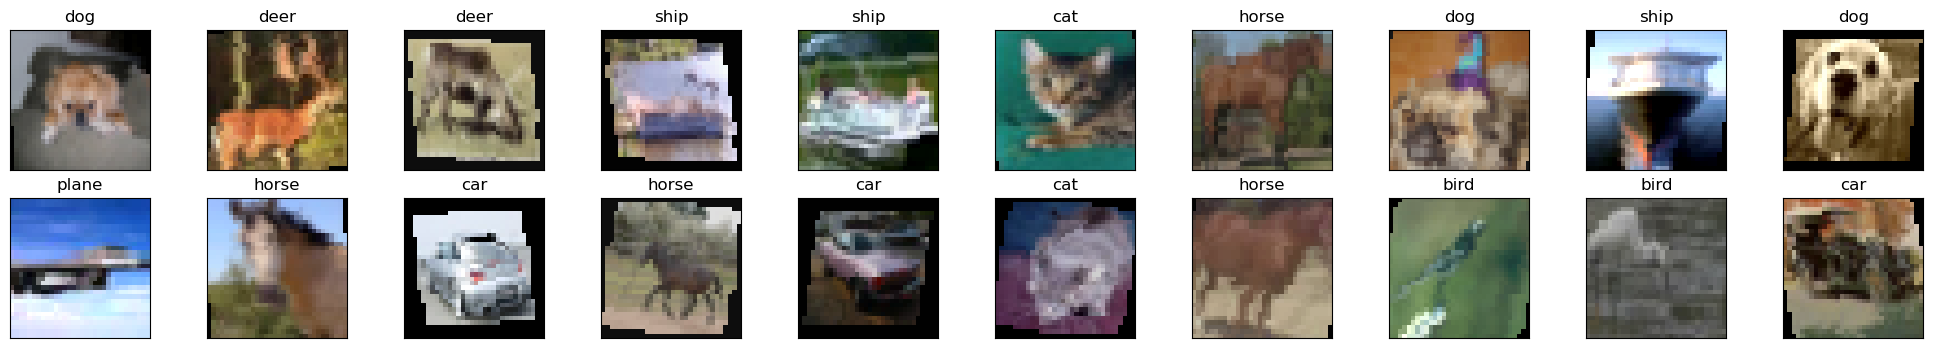

In [7]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [8]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1) # in-channels=3,out-channels=16, kernel_size=3, stride=1
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1) #padding=1 equiv à +1 pixel au alentour
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [9]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [10]:
from torchsummary import summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
            Conv2d-2           [-1, 32, 16, 16]           4,640
            Conv2d-3             [-1, 64, 8, 8]          18,496
            Linear-4                  [-1, 500]         512,500
           Dropout-5                  [-1, 500]               0
            Linear-6                   [-1, 10]           5,010
Total params: 541,094
Trainable params: 541,094
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.23
Params size (MB): 2.06
Estimated Total Size (MB): 2.30
----------------------------------------------------------------


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [12]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad() # pytorch accumulates gradients
    loss.backward() # gradient claculation for the previous layer
    optimizer.step() # update weights
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad(): # No update weights
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.6871, acc 37.9060 
validation loss: 1.4188, validation acc 49.1900 
epoch : 2
training loss: 1.3906, acc 49.8340 
validation loss: 1.2513, validation acc 55.3200 
epoch : 3
training loss: 1.2553, acc 54.9760 
validation loss: 1.1654, validation acc 59.0400 
epoch : 4
training loss: 1.1657, acc 58.6500 
validation loss: 1.0420, validation acc 63.1200 
epoch : 5
training loss: 1.0902, acc 61.3460 
validation loss: 0.9853, validation acc 65.3800 
epoch : 6
training loss: 1.0412, acc 63.1660 
validation loss: 0.9395, validation acc 67.1600 
epoch : 7
training loss: 0.9993, acc 64.9260 
validation loss: 0.9005, validation acc 68.6300 
epoch : 8
training loss: 0.9594, acc 66.3460 
validation loss: 0.8649, validation acc 69.7300 
epoch : 9
training loss: 0.9389, acc 67.3220 
validation loss: 0.8832, validation acc 69.3200 
epoch : 10
training loss: 0.9145, acc 68.0680 
validation loss: 0.8453, validation acc 70.7000 
epoch : 11
training loss: 0.8877, acc 68.8640 
va

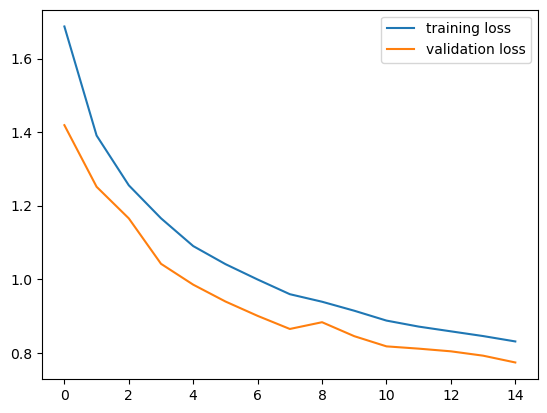

In [13]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

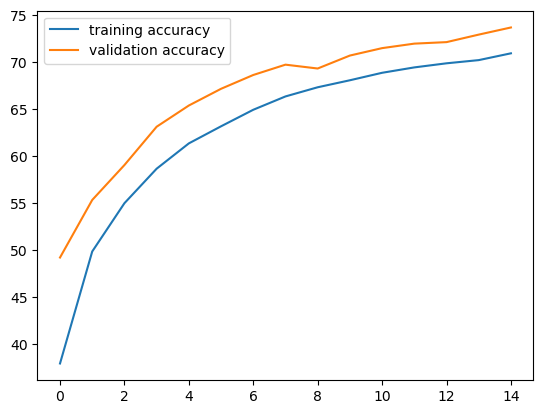

In [14]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [15]:
import PIL.ImageOps # PIL (Python Imaging Library)

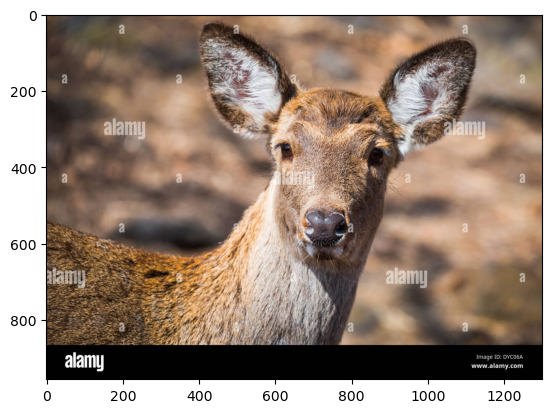

In [16]:
import requests
from PIL import Image

url = 'https://c8.alamy.com/comp/DYC06A/hornless-reindeer-at-zoo-DYC06A.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

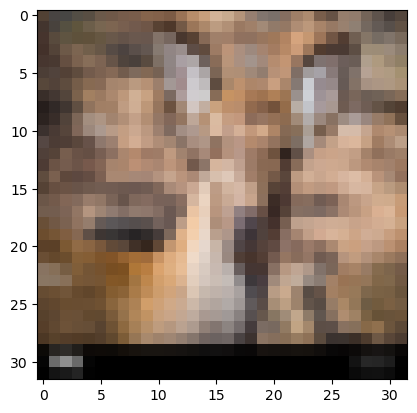

In [18]:
img = transform_test(img) 
plt.imshow(im_convert(img))

In [19]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

deer


In [20]:
output

tensor([[-2.3006, -5.7382,  1.3828,  1.3742,  2.0921,  0.6586,  0.1879,  0.2344,
         -6.3760, -4.3213]], grad_fn=<AddmmBackward0>)

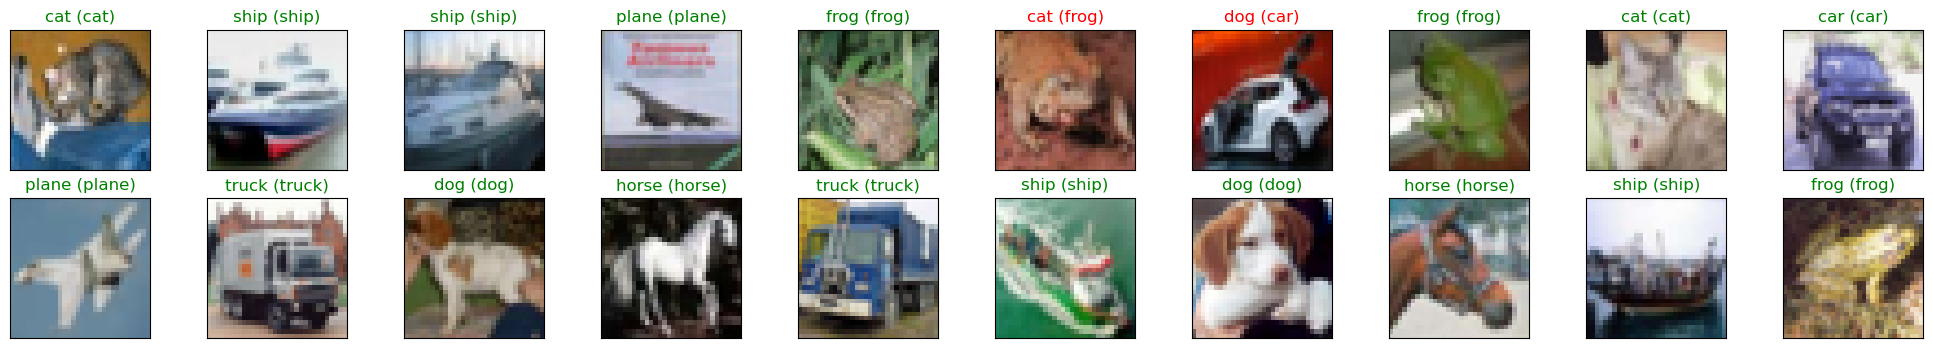

In [21]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

Note - LeNet model with:

* Learning rate = 0.00001
* padding = 0 
* without data augmentation 

gives 64% accuracy 